In [4]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split
from PIL import Image
import cv2
import matplotlib.pyplot as plt

ImportError: DLL load failed while importing cv2: The specified module could not be found.

In [ ]:
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Transformasi data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ]),
}

# Load dataset training dan testing
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Pembagian data training dan validasi
train_size = int(0.8 * len(train_data))  # 80% untuk training
val_size = len(train_data) - train_size  # 20% untuk validasi
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Data loader untuk training, validasi, dan test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [55]:
# Model CNN untuk deteksi kantuk
class DrowsinessCNN(nn.Module):
    def __init__(self):
        super(DrowsinessCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [2]:
# Inisialisasi model, loss function, dan optimizer
model = DrowsinessCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training model dengan validasi
num_epochs = 12
train_loss, val_loss = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        labels = labels.view(-1, 1).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))

    # Validasi setiap epoch
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:  # Gunakan val_loader
            labels = labels.view(-1, 1).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_loss.append(val_running_loss / len(val_loader))
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}')

NameError: name 'DrowsinessCNN' is not defined

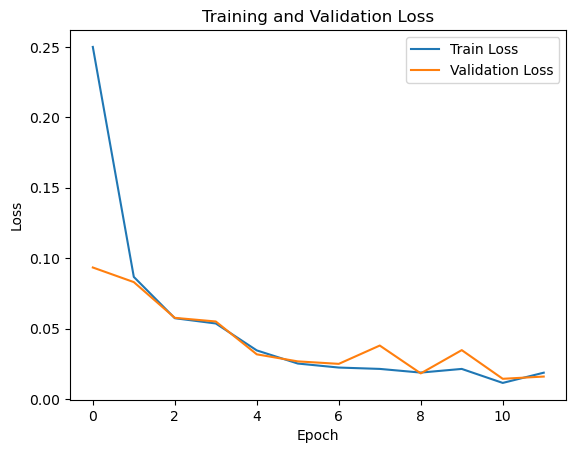

In [69]:
# Plot hasil training
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Fungsi untuk prediksi gambar tunggal
def predict_image(image_path):
    model.eval()
    image = Image.open(image_path)
    image = data_transforms['test'](image).unsqueeze(0)
    output = model(image)
    pred = torch.round(output).item()
    return 'Mengantuk' if pred == 1 else 'Tidak Mengantuk'

# Contoh prediksi pada gambar
print(predict_image('test1.jpg'))  # Ubah ke nama file gambar yang sesuai

# Pengaturan ambang batas waktu mata tertutup
CLOSED_EYE_THRESHOLD = 2.0  

# Fungsi prediksi frame untuk kamera
def predict_frame(frame):
    model.eval()
    frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    frame = data_transforms['test'](frame).unsqueeze(0)
    output = model(frame)
    pred = torch.round(output).item()
    return pred  # 1 untuk mata tertutup, 0 untuk mata terbuka

# Prediksi dan deteksi kantuk real-time dengan kamera
def real_time_drowsiness_detection():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Kamera tidak dapat dibuka")
        return

    eye_closed_start_time = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Gagal membaca frame")
            break

        eye_closed = predict_frame(frame)
        
        # Jika mata tertutup, mulai hitung waktu
        if eye_closed == 1:
            if eye_closed_start_time is None:
                eye_closed_start_time = time.time()
            elapsed_time = time.time() - eye_closed_start_time
            print(f"Durasi mata tertutup: {elapsed_time:.2f} detik")

            # Jika durasi mata tertutup melebihi ambang batas, tampilkan peringatan
            if elapsed_time >= CLOSED_EYE_THRESHOLD:
                cv2.putText(frame, "WARNING: Mengantuk!", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        else:
            eye_closed_start_time = None

        # Status prediksi
        status_text = "Mengantuk" if eye_closed == 1 else "Tidak Mengantuk"
        cv2.putText(frame, f'Status: {status_text}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Tampilkan frame
        cv2.imshow('Drowsiness Detection', frame)

        # Tekan 'q' untuk keluar
        if cv2.waitKey(1) & 0xFF == ord('s'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Jalankan deteksi kantuk real-time
real_time_drowsiness_detection()

Tidak Mengantuk
